# Packages

In [117]:
## import the useful packages 

from tqdm import tqdm
import numpy as np
import json, requests 
import pandas as pd
import time


import unicodedata
from metaphone import doublemetaphone
from fuzzywuzzy import fuzz
from difflib import SequenceMatcher
import re
from math import radians, cos, sin, asin, sqrt

from scipy.stats import chi2

from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

#import spacy
#!python -m spacy download en_core_web_lg
#spacy_nlp = spacy.load("en_core_web_lg")

import random 

import geopy.distance
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import networkx as nx
import psycopg2 

/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
main_path  = '/home/fs01/spec1142/Emma/GateKeepers/'


In [14]:
f = open(main_path + "database.txt", "r")
user , password = f.read().split()



# Queries - self citations

## Name comparison _ Functions

Import and load the necessary functions and dictionaries

In [5]:
## load dictionary with the distribution of the last names: 
f = open(main_path + "frequency_last_names.json","r")
import json
dic_last_names = json.load(f)


## load dictionary with the distribution of the first names: 
f = open(main_path + "frequency_first_names.json","r")
import json
dic_first_names = json.load(f)

In [6]:
#suppress all the unwanted suffixes from a string. 
#name_del file can be modified if more or less suffixes want to be suppressed 

name_del = ["2nd", "3rd", "jr", "jr.", "junior", "sr", "sr.", "senior", "i", 'ii' , 'iii']

def name_delete(string):
    for elmt in name_del:
        if f" {elmt}" in string:
            return string.replace(f" {elmt}","")
    return string



#merge the nobiliary particles with the last name
#ln_suff file can be modified if more or less nobiliary particles want to be suppressed

ln_suff= ["oster", "nordre", "vaster", "aust", "vesle", "da", "van t", "af", "al", "setya", "zu", "la", "na", "mic", "ofver", "el", "vetle", "van het", "dos", "ui", "vest", "ab", "vste", "nord", "van der", "bin", "ibn", "war", "fitz", "alam", "di", "erch", "fetch", "nga", "ka", "soder", "lille", "upp", "ua", "te", "ni", "bint", "von und zu", "vast", "vestre", "over", "syd", "mac", "nin", "nic", "putri", "bet", "verch", "norr", "bath", "della", "van", "ben", "du", "stor", "das", "neder", "abu", "degli", "vre", "ait", "ny", "opp", "pour", "kil", "der", "oz",  "von", "at", "nedre", "van den", "setia", "ap", "gil", "myljom", "van de", "stre", "dele", "mck", "de", "mellom", "mhic", "binti", "ath", "binte", "snder", "sre", "ned", "ter", "bar", "le", "mala", "ost", "syndre", "sr", "bat", "sndre", "austre", "putra", "putera", "av", "lu", "vetch", "ver", "puteri", "mc", "tre", "st"]

def ln_suff_merge(string):
    for suff in ln_suff:
        if f" {suff} " in string or string.startswith(f"{suff} "):
            return string.replace(f"{suff} ",suff.replace(" ",""))
    return string
    

In [8]:
#normalize a string dat that represents often a name. 

def normalize(data):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    # lower full name in upper
    val = re.sub(r"[A-Z]{3,}", lambda x: x.group().lower(), val)
    # add space in front of upper case
    if "Mac" not in val and "Mc" not in val:
        val = re.sub(r"(\w)([A-Z])", r"\1 \2", val)
    # Lower case
    val = val.lower()
    # delete unwanted elmt
    val = name_delete(val)
    # remove special characters
    val = re.sub('[^A-Za-z0-9 -]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    # remove trailing spaces
    val = val.strip()

    return val

normalize("PIERRE De BEHRMAN")

'pierre de behrman'

In [9]:
#return a ratio of similarity of letters between two strings (to handle in the first names errors)

def match_ratio(string1,string2):
    return fuzz.ratio(string1, string2)


In [10]:
#return 4 if string1 and string2 are the same
#return 3 if string1 and string2 sound the same
#otherwise, return less

def metaphone(string1,string2):
    if string1==string2:
        return 4
    tuple1 = doublemetaphone(string1)
    tuple2 = doublemetaphone(string2)
    if tuple1[0] == tuple2[0]:
        return 3
    elif tuple1[0] == tuple2[1] or tuple1[1] == tuple2[0]:
        return 2
    elif tuple1[1] == tuple2[1]:
        return 1
    else:
        return 0

In [11]:
#compare name1 and name2. Return 1 if name1 and name2 might represent the same individual, otherwise 0.
def comparison(name1 , name2):
    
    if name1 == name2:
        return 1
    
    #if there is no first name, retrun it's a match
    if name1 == "" or name2 == "":
        return 1
    
    #if some first names exist:
    list_name1 = name1.split()
    list_name2 = name2.split()
    
    #minimum number of first names to match
    number_match = min( len(list_name1) , len(list_name2))
    
    #for each name, check if there is a match
    count_match = 0
    for elem1 in list_name1:
        match = 0
        
        #if we just have the initial:
        if len(elem1) == 1:
            for elem2 in list_name2:
                if elem1[0] == elem2[0]:
                    match = 1
        else:
            for elem2 in list_name2:
                #if we just have the initial:
                if len(elem2) == 1 and elem1[0] == elem2[0]:
                    match = 1
                    
                #if elem1 and elem2 are entire first names that sound the same and have a ratio of common letters higher thsan 85%, it's a match
                elif len(elem2) > 1 and (metaphone(elem1,elem2) > 2 or match_ratio(elem1 , elem2) > 85 ) :
                    match = 1
                    
        #count the number of first names that match    
        count_match += match
        
    #check if we have enough first names that match 
    if count_match < number_match:
        return 0
    else:
        return 1


In [13]:
#quantify the similarity between two names 
def score(author , inventor , name):
    
    score = 0
    
    #get the distribution of the last names (from the dictionary dic_last_names)
    #it's possible to change the distribution of the last names by changing the dictionary
    name = normalize(name)
    if name in dic_last_names:
        dist = dic_last_names[name]
    else:
        dist = 0        
   
    #remove the last name from the author name

    author_names = " ".join([ elem[0] + " " + elem[1] if len(elem)==2 else elem for elem in author.split() ]).split()

    if name in author_names:
        author_names.remove(name)
    
    inventor_names = inventor.split()

    if name in inventor_names:
        inventor_names.remove(name)

    
    #sorte the cleaned author name by the lenght of the first names if there is the initial of the middle name
    if len(inventor_names) > 1 and len(inventor_names[1]) > 1 and len(inventor_names[0]) < 3:
        inventor_names = sorted(inventor_names, key=len, reverse=True)
    if len(author_names) > 1 and len(author_names[1]) > 1 and len(author_names[0]) <3 :
        author_names = sorted(author_names , key=len , reverse=True)
    
  
    #if there is not first name, the socre is 0.4
    if author_names == [] or inventor_names == []:
        score = 0.4


    #if both author and inventor have an entire first name (not just initial)
    elif len(author_names[0]) > 2 and len(inventor_names[0]) > 2:
        
        #if the first names match:
        if author_names[0] == inventor_names[0]:
            
            #we add the first name distribution to the distribution of the full name
            if author_names[0] in dic_first_names:
                dist_first_name = dic_first_names[author_names[0]]
            else:
                dist_first_name = 0
                
            #if a middle name match, the score is 1 
            #if len(set(author_names) & set(inventor_names)  ) > 1: 
            #    dist = dist*(1-0.4*dist_first_name)
            #    score = 1
            
            if len(author_names) > 1 and len(inventor_names) > 1 and author_names[1][0] == inventor_names[1][0]:
                dist = dist*(1-0.4*dist_first_name)
                score = 1
            
            
            #if there is no middle name, the score is 0.8
            else:
                dist = dist*(1-0.4*dist_first_name)
                score = 0.8
                
        #if the first names don't match:
        else:
            #if the first names sound the same and have more than 85% of letters in common, the score is 0.7
            if (metaphone(author_names[0],inventor_names[0])) > 2 or match_ratio(author_names[0],inventor_names[0]) > 85 :
                
                #we add the first name distribution to the distribution of the full name
                if inventor_names[0] in dic_first_names:
                    dist_first_name = dic_first_names[inventor_names[0]]
                else:
                    dist_first_name = 0
                dist = dist*(1-0.4*dist_first_name)
                score = 0.7
                    
            #else, the score is 0.1
            else:
                score = 0.1
    
    #if the author or the inventor only have an initial:
    
    elif len(author_names[0]) < 3 or len(inventor_names[0]) < 3:

        inventor_names = inventor.split()
        #if only the first initial of the author matches with the first initial of the inventor, the score is 0.6

        if author_names[0][0] == inventor_names[0][0]:
            score = 0.6
            
            
            #if more than one initial are matching, the score is 0.8
            if len(author_names) > 1 and len(inventor_names) > 1 and author_names[1][0] == inventor_names[1][0]:
                score = 0.8
        #if only a middle initial matches with am initial, the score is 0.2
        else:
            score = 0.2
    
    #return the similarity between the inventor and author name, the distribution of the matching name, 
    #the author and inventor names and the similarity between the inventor and author name normalize by the distribution of the name. 
    return   score, dist,  author  , inventor , score /(1 + dist)
    
        

## Queries and analysis

In [23]:
## select the patents and cited papers from Matt file where "confscore = 10" and "selfciteconf_max > 0" 
## list the correspoonding co-inventor's names, co-author's names and orcid from the local database. 

#establishing the connection
conn = psycopg2.connect("user=" + user + " password=" + password )

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#query the patents, papers and authors/inventors names and orcid
text = """ SELECT npc.patent_id, npc.work_id, array_agg( concat(i.disambig_inventor_name_first ,  ' ' , i.disambig_inventor_name_last) ), array_agg( concat(a.display_name , ' ' , a.orcid)) 
              FROM non_patent_citations_matt_marx AS npc
              JOIN inventors_PatentsView as i ON SUBSTRING(npc.patent_id , 4 , 20) = i.patent_id
              JOIN works_authors_OpenAlex as wa ON npc.work_id = wa.work_id
              JOIN authors_OpenAlex as a ON wa.author_id = a.author_id
              WHERE npc.self = 'isself' AND confscore = 10 
              GROUP BY npc.patent_id, npc.work_id
              ; """



cursor.execute(text)  
res = cursor.fetchall()

print("Number of results" , len(res))

    
cursor.close()


Number of results 1379920


In [ ]:
## organize the results in a dictionary and count the number of authors in common 
## the keys are the patent_id separated from the work id (starting with W) with a space
## the values are the number of authors-inventors in common, their names and orcid and a confidence score (similarity names + frequency of the names) 

dic_self_citations = {}

for line in tqdm(res):
    
    #for each papers - patents couple, store the work and patent id
    patent_id = line[0]
    work_id = line[1]
    
    #get list of inventors names, and authors names and orcid
    list_inventors = set(line[2])
    list_authors_orcid = set(line[3].split(","))
    
    #compare the inventor's name with the author's name
    for inventor in list_inventors:
        
        names_inventor = set(inventor.split())
        
        for author_orcid in list_authors_orcid:
            
            if "http" in author_orcid:
                author = " ".join(author_orcid.split()[:-1])
                orcid = author_orcid.split()[-1]
            else:
                author = author_orcid
                orcid = None
            
            names_author = set(author.split())
            
            #keep the authors/inventors names in common
            if len(names_inventor & names_author)  > 0  and comparison(author , inventor) == 1:
                
                if patent_id + " " + work_id not in dic_self_citations:
                    dic_self_citations[patent_id + " " + work_id] = {}
                    dic_self_citations[patent_id + " " + work_id]["number in common"] = 0
                    dic_self_citations[patent_id + " " + work_id]["names in common"] = {}
                
                dic_self_citations[patent_id + " " + work_id]["number in common"] += 1
                dic_self_citations[patent_id + " " + work_id]["names in common"][author + " # " + inventor] = {}
                
                #quantify the similarity between the inventor/author names in common 
                try:
                    dic_self_citations[patent_id + " " + work_id]["names in common"][author + " # " + inventor]["score"] = score(author , inventor ,inventor.split()[-1]) [-1]
                except:
                    dic_self_citations[patent_id + " " + work_id]["names in common"][author + " # " + inventor]["score"] = 0
                dic_self_citations[patent_id + " " + work_id]["names in common"][author + " # " + inventor]["orcid"] = orcid


In [28]:
## we keep only the patents and cited papers with more 2 or more authors-inventors in common with a confidence score > 0.75 
## where at least one these authors-inventors in common have an orcid

dic_self_citations2 = {}
for elem in dic_self_citations:
    
    #look only at the patents - papers couple with two or more author/inventor names in common
    if dic_self_citations[elem]["number in common"] > 1:
        k = 0
        list_orcid = []
        for names in dic_self_citations[elem]["names in common"]:
            
            #look only at the patents - papers couple with two or more author/inventor names with a score > 0.75
            if dic_self_citations[elem]["names in common"][names]["score"] > 0.75:
                k += 1
                if dic_self_citations[elem]["names in common"][names]["orcid"] != None:
                    list_orcid.append(dic_self_citations[elem]["names in common"][names]["orcid"])
            
        #keep only the patents - papers couple with two or more authors/inventors in common with unfamilar names and one with an orcid
        if k > 1 and len(list_orcid) > 0:
            for orcid in list_orcid:
                if elem.split()[0] + " " + orcid not in dic_self_citations2:
                    dic_self_citations2[elem.split()[0] + " " + orcid] = dic_self_citations[elem]
                    dic_self_citations2[elem.split()[0] + " " + orcid]["cited_work"] = elem.split()[1]


In [29]:
print("Number of results" , len(dic_self_citations2))

Number of results 114


In [228]:
## Save the results

import json
json = json.dumps(dic_self_citations2)
f = open(main_path + "train_the_model/self_citations.json","w")
f.write(json)
f.close()

# Extended training set - 10 papers with the same ORCID

## Functions

In [33]:
## load dictionary with the selected patent's number - orcid corresponding to the same individual 

f = open(main_path + "train_the_model/self_citations.json","r")
import json
dic_self_citations2 = json.load(f)

len(dic_self_citations2)

47354

### Query from OpenAlex and PatentsView

In [36]:
#create a URl, that will be used for OpenAlex and Patentsview
def URL(base_URL , entity_type , filters):
    url = base_URL + entity_type + filters 
    return url

#from an internet link, extract the data and load the data in the jyputer notebook 
def get_data(url):
    url = requests.get(url)
    text = url.text
    import json
    data = json.loads(text)
    return data

### Encoded texts

In [43]:
## transform the encoded title and abstract strings into lists

def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text

In [44]:
## reconstruct the abstract from the inverted index


def reconstruction_abstract(abstract_inverted_index):
    # return the abstract is the abstract exists in the database, else, return None
    
    if abstract_inverted_index != '' and abstract_inverted_index != None and abstract_inverted_index != {} and abstract_inverted_index["InvertedIndex"] != {}:
        size = abstract_inverted_index["IndexLength"]
        text = np.full_like(np.empty((size)), '', dtype = 'object')
        for k,values in abstract_inverted_index["InvertedIndex"].items():
            for v in values:
                text[v] = k
        
        return ' '.join(text)
    else:
        # return none if there is no abtract
        return None



### Get coordinates from an institution name 

In [34]:
## load dictionary with the missing institutions (key: display name, values: city, country, longitude, latitude) 

institutions = pd.read_csv("/home/fs01/spec1142/Emma/Download_OpenAlex/OA_institutions/institutions_up_to_20230817.tsv" , delimiter = "\t", index_col = 0 )
dic_institutions = institutions.to_dict("index")


## load dictionary with the missing institutions (key: display name, values: city, country, longitude, latitude) 

# extract all the cities from the OpenAlex institutions, as well as their locations (longitude latitude) 

#flatten the institution dictionary
for institution in list(dic_institutions.keys()):
    dic_institutions[institution]["region"] = dic_institutions[institution]["region"]
    dic_institutions[institution]["city"] = dic_institutions[institution]["city"]
    dic_institutions[institution]["longitude"] = dic_institutions[institution]["longitude"]
    dic_institutions[institution]["latitude"] = dic_institutions[institution]["latitude"]
    dic_institutions[institution]["country"] = dic_institutions[institution]["country"]
    

#store the longitude / latitude cooresponding to the cities
dic_cities = {}

for institution in list(dic_institutions.keys()):
    if dic_institutions[institution]["city"] not in dic_cities and dic_institutions[institution]["latitude"] != None:
        dic_cities[dic_institutions[institution]["city"]] = []
    if dic_institutions[institution]["city"] in dic_cities and [ dic_institutions[institution]["latitude"] , dic_institutions[institution]["longitude"] ] not in dic_cities[dic_institutions[institution]["city"]]:
        dic_cities[dic_institutions[institution]["city"]].append([ dic_institutions[institution]["latitude"] , dic_institutions[institution]["longitude"] ])
    



#get the list of the cities and of the countries from OpenAlex institution table
table = pd.DataFrame(dic_institutions).T    

list_cities = set(table["city"].tolist())
list_countries = set(table["country"].tolist())
list_country_codes = set(table["country_code"].tolist())
 

#get the location from an institution mame
def get_location_display_name(display_name):
    #clean the institution name
    display_name = ''.join([i for i in display_name if not i.isdigit()])
    display_name = display_name.replace("*" , "")
    display_name = display_name.replace("#TAB#" , "")
    display_name = display_name.replace("  " , " ")
    
    #extract the location and organisation from the institution name
    doc = spacy_nlp(display_name.strip())
    location_entities= set()
    organization_entities = set()
    for i in doc.ents:
        entry = str(i.lemma_).lower()
        display_name = display_name.replace(str(i).lower(), "")
        if i.label_ in ["GPE", "GEO","LOC"]:
            location_entities.add(i)
        if i.label_ in ["ORG"]:
            organization_entities.add(i)
            
    #return         
    return location_entities , organization_entities

#get the coordinates from an institution name
def get_location_missing( display_name):
    
    # extract all the cities from the OpenAlex institutions, as well as their locations (longitude latitude) 

    #get the location from an institution name
    dic = {}
    location = get_location_display_name(display_name)[0]
    cities = set()
    countries = set()
                    
                    
    #search a cooresponding city in OpenAlex institution's cities                
    for elem in location:
        elem = str(elem).title()
                    
        if elem in list_cities and elem in dic_cities:
            cities.add(elem)

        if elem in list_countries or elem in list_country_codes:
            countries.add(elem)
                
    dic["city"] = list(cities - countries)
    dic["country"] = list(countries)
    
    #get the coordinates associated with a city
    if cities != set():
        dic["longitude"] = float(dic_cities[list(cities)[0]][0][1])
        dic["latitude"] = float(dic_cities[list(cities)[0]][0][0])
        
    #return a dictionary where the key is the institution names and the values are the city, country, longitude, latitude
    return dic




def get_long_lat(institution_name):
    
    #check if the institution id is already in the dictionary
    if institution_name in dic_missing_ids and "longitude" in dic_missing_ids[institution_name]:
        return dic_missing_ids[institution_name]["longitude"] , dic_missing_ids[institution_name]["latitude"]
    
    #otherwise, try to extract a city name and its coordinates
    else:
        dic = get_location_missing( institution_name )
        dic_missing_ids[institution_name] = dic
        if "longitude" in dic:
            return float(dic["longitude"]) , float(dic["latitude"])
        else:
            return None, None
    

## Queries

In [50]:
## get up to 5 works corresponding to each orcid 
## get the useful data on the works  
## get the useful data on the patents  


#establishing the connection
conn = psycopg2.connect("user=" + user + " password=" + password )

#Creating a cursor object using the cursor() method
cursor = conn.cursor()


#store the useful data
dic_patents = {}
dic_papers = {}


#count the number of patents - orcid done
ccount = 0


for elem in list(dic_self_citations2.keys())[:3]:
    
    try:
        
        #query up to 5 works corresponding to the orcid
        orcid = elem.split()[1]
        if orcid not in dic_papers:

            dic_papers_inter = {}
            dic_papers_inter["papers"] = {}
            dic_papers_inter["data"] = {}
            
            #query from OpenAlex
            base_URL_OA = f'https://api.openalex.org/'
            filter_authors = f'works?filter='
            filter_by_name = f"authorships.author.orcid:" + orcid + ",has_abstract:true&page=1&per_page=200&mailto=emma_scharfmann@berkeley.edu"
            url = URL(base_URL_OA , filter_authors, filter_by_name)
            data = get_data(url)["results"]
            count = len(data)
            
            #if works corresponding to the orcid are found: 
            if count > 0:
                
                #get the list of the up 200 works display by Openalex corresponding to the orcid
                list_dates_author = [ data[i]["publication_year"] for i in range(len(data))]

                
                #get the last known institution and coordinates of the author corresponding to the orcid
                text = """ SELECT i.longitude, i.latitude , a.last_known_institution_display_name
                               FROM authors_OpenAlex AS a
                               LEFT JOIN institutions_OpenAlex AS i ON a.last_known_institution_id = i.institution_id
                               WHERE a.orcid = '""" + orcid + """' 
                               LIMIT 1;"""

                cursor.execute(text)  
                res = cursor.fetchall()

                for line in res:
                    
                    #get institution name
                    author_institution_name = line[2]
                    
                    #if coordinates exist:
                    if line[0] != None:
                        author_longitude = line[0]
                        author_latitude  = line[1]
                    
                    #otherwise, try to extract a city name and its coordinates
                    else:
                        author_longitude , author_latitude = get_long_lat(author_institution_name)

                #store the author's data
                dic_papers_inter["data"] =  { "list_dates" : list_dates_author,
                                              "max_dates" : max(list_dates_author),
                                              "min_dates" : min(list_dates_author),
                                              "mean_dates" : np.mean(list_dates_author),
                                              "chi_dist" : chi2.fit(list_dates_author),
                                              "author_longitude" : author_longitude,
                                              "author_latitude" : author_latitude,
                                              "author_institution_name" : author_institution_name } 

                #get the works data 
                for i in range(min(count , 5)):
                    data_paper = data[i]
                    work_id = data_paper["id"][21:]
                    dic_papers_inter["papers"][work_id] = {}
                    dic_papers_inter["papers"][work_id]["publication_year"] = data_paper["publication_date"]
                    dic_papers_inter["papers"][work_id]["referenced_works"] = [ ref[21:] for ref in data_paper["referenced_works"]]
                    dic_papers_inter["papers"][work_id]["concepts"] = [ concept["display_name"] for concept in data_paper["concepts"]]
                    dic_papers_inter["papers"][work_id]["co_authors"] = [ name["author"]["display_name"] for name in data_paper["authorships"] if name["author"]["display_name"] != None]


                    #get the institutions and coordinates of the author cooresponding to the orcid 
                    for k in range(len(data_paper["authorships"])):
                        if data_paper["authorships"][k]["author"]["orcid"] == orcid:
                            if len(data_paper["authorships"][k]["institutions"]) > 0:
                                dic_papers_inter["papers"][work_id]["institution_name"] = " ".join([ elem["display_name"] for elem in data_paper["authorships"][k]["institutions"]] )
                                
                                #if an institution id exists, get the coordinates
                                if "id" in data_paper["authorships"][k]["institutions"][0] and data_paper["authorships"][k]["institutions"][0]["id"] != None:
                                    institution_id = data_paper["authorships"][k]["institutions"][0]["id"]

                                    text = """ SELECT longitude , latitude 
                                                FROM institutions_OpenAlex 
                                                WHERE institution_id = '""" + institution_id + """' 
                                                LIMIT 1;"""

                                    cursor.execute(text)  
                                    res = cursor.fetchall()

                                    for line in res:
                                        dic_papers_inter["papers"][work_id]["longitude"] = line[0]
                                        dic_papers_inter["papers"][work_id]["latitude"] = line[1]

                                #otherwise, try to extract a city name and its coordinates
                                else:
                                    institution_name = data_paper["authorships"][k]["institutions"][0]["display_name"]
                                    dic_papers_inter["papers"][work_id]["longitude"] , dic_papers_inter["papers"][work_id]["latitude"] = get_long_lat(institution_name)
                            else:
                                dic_papers_inter["papers"][work_id]["longitude"] = None
                                dic_papers_inter["papers"][work_id]["latitude"] = None
                                dic_papers_inter["papers"][work_id]["institution_name"] = None


                    #get the encoded title and abstract, or compute them
                    text = """ SELECT encoded_title , encoded_abstract 
                               FROM encoded_works_OpenAlex 
                               WHERE work_id = '""" + work_id + """' 
                               LIMIT 1;"""

                    cursor.execute(text)  
                    res = cursor.fetchall()

                    if len(res) == 0:
                        
                        if data_paper["title"] != None:
                            dic_papers_inter["papers"][work_id]["encoded_title"] =  model.encode(data_paper["title"] , convert_to_tensor = True).tolist()
                        else:
                            dic_papers_inter["papers"][work_id]["encoded_title"] = None
                        if data_paper["abstract_inverted_index"] != None:
                            dic_papers_inter["papers"][work_id]["encoded_abstract"] = model.encode(reconstruction_abstract(data_paper["abstract_inverted_index"]) , convert_to_tensor = True).tolist()
                        else:
                            dic_papers_inter["papers"][work_id]["encoded_abstract"] = None


                    for line in res:
                        if line[0] != None and line[0] != '':
                            dic_papers_inter["papers"][work_id]["encoded_title"] = clean_encoding(line[0])

                        if line[1] != None and line[1] != '':
                            dic_papers_inter["papers"][work_id]["encoded_abstract"] = clean_encoding(line[1])
                            
            #store the papers' data into the dictionary                
            dic_papers[orcid] = dic_papers_inter


        #query the patent's useful data
        patent_id = elem.split()[0]
        if patent_id not in dic_patents:

            for name in dic_self_citations2[elem]['names in common']:
                
                #get the author in common 
                if orcid == dic_self_citations2[elem]['names in common'][name]["orcid"]:     
                    inventor_name = name.split(" # ")[1]

            
            #get the useful data from the database
            dic_inter_patents = {}
            text = """ SELECT p.patent_id , p.patent_date , pe.encoded_title , pe.encoded_abstract, array_agg( concat(i.disambig_inventor_name_first , ' ' , i.disambig_inventor_name_last  , '&' ,  li.longitude , '&' , li.latitude))  , a.disambig_assignee_organization , l.longitude , l.latitude ,array_agg(npc.work_id) 
                           FROM patents_PatentsView AS p
                           LEFT JOIN encoded_patents_PatentsView AS pe ON pe.patent_id = '""" + patent_id[3:] + """'
                           LEFT JOIN inventors_PatentsView AS i ON i.patent_id = '""" + patent_id[3:] + """'
                           LEFT JOIN assignees_PatentsView AS a ON a.patent_id = p.patent_id 
                           LEFT JOIN locations_PatentsView AS l ON a.location_id = l.location_id
                           LEFT JOIN locations_PatentsView AS li ON i.location_id = li.location_id
                           LEFT JOIN non_patent_citations_matt_marx AS npc ON npc.patent_id = '""" + patent_id + """'
                           WHERE  p.patent_id = '""" + patent_id[3:] + """' 
                           GROUP BY p.patent_id , p.patent_date , pe.encoded_title , pe.encoded_abstract ,a.disambig_assignee_organization , l.longitude , l.latitude 
                           LIMIT 1;"""

            cursor.execute(text)  
            res = cursor.fetchall()

            for line in res:
                dic_inter_patents["patent_date"] = line[1]
                dic_inter_patents["encoded_title"] = clean_encoding(line[2])
                dic_inter_patents["encoded_abstract"] = clean_encoding(line[3])
                if line[4] != None:
                    dic_inter_patents["co_inventors"] = list(set([ word.split("&")[0] for word in line[4] if word != None] ))
                if line[5] != None:
                    dic_inter_patents["assignee_organization"] = line[5].replace("\"" , "")
                else:
                    dic_inter_patents["assignee_organization"] = None
                dic_inter_patents["assignee_longitude"] = line[6]
                dic_inter_patents["assignee_latitude"] = line[7]
                dic_inter_patents["cited_papers"] = list(set(line[8]))
                if len(list(set([ word.split("&")[1] for word in line[4] if word.split("&")[0] == inventor_name ]))) > 0:
                    dic_inter_patents["inventor_longitude"] = float(list(set([ word.split("&")[1] for word in line[4] if word.split("&")[0] == inventor_name ]))[0])
                    dic_inter_patents["inventor_latitude"] = float(list(set([ word.split("&")[2] for word in line[4] if word.split("&")[0] == inventor_name ]))[0])
                else:
                    dic_inter_patents["inventor_latitude"]= None
                    dic_inter_patents["inventor_longitude"] = None



            #store the data into the dictionary 
            dic_patents[patent_id] = dic_inter_patents
            
        ccount += 1
    
        intermediate save of the dictionaries (every 5000 iterations) 
        if ccount % 5000 == 0:
            import json
            json = json.dumps(dic_patents)
            f = open(main_path + "train_the_model/self_citations_dic_patents.json","w")
            f.write(json)
            f.close()#
            import json
            json = json.dumps(dic_papers)
            f = open(main_path + "train_the_model/self_citations_dic_papers.json","w")
            f.write(json)
            f.close()
        
   except:
        continue
        

final save of the dictionaries       
import json
json = json.dumps(dic_patents)
f = open(main_path + "train_the_model/self_citations_dic_patents.json","w")
f.write(json)
f.close()

import json
json = json.dumps(dic_papers)
f = open(main_path + "train_the_model/self_citations_dic_papers.json","w")
f.write(json)
f.close()

# Training set

## Functions

### Dictionaries

In [3]:
## load dictionary with the distribution of the last names: 
f = open(main_path + "frequency_last_names.json","r")
import json
dic_last_names = json.load(f)


## load dictionary with the distribution of the first names: 
f = open(main_path + "frequency_first_names.json","r")
import json
dic_first_names = json.load(f)

In [6]:
dic_missing_ids = {}

### Functions

#### Clean the names

#### Comparison names

In [6]:
#suppress all the unwanted suffixes from a string. 
#name_del file can be modified if more or less suffixes want to be suppressed 

name_del = ["2nd", "3rd", "jr", "jr.", "junior", "sr", "sr.", "senior", "i", 'ii' , 'iii']

def name_delete(string):
    for elmt in name_del:
        if f" {elmt}" in string:
            return string.replace(f" {elmt}","")
    return string



#merge the nobiliary particles with the last name
#ln_suff file can be modified if more or less nobiliary particles want to be suppressed

ln_suff= ["oster", "nordre", "vaster", "aust", "vesle", "da", "van t", "af", "al", "setya", "zu", "la", "na", "mic", "ofver", "el", "vetle", "van het", "dos", "ui", "vest", "ab", "vste", "nord", "van der", "bin", "ibn", "war", "fitz", "alam", "di", "erch", "fetch", "nga", "ka", "soder", "lille", "upp", "ua", "te", "ni", "bint", "von und zu", "vast", "vestre", "over", "syd", "mac", "nin", "nic", "putri", "bet", "verch", "norr", "bath", "della", "van", "ben", "du", "stor", "das", "neder", "abu", "degli", "vre", "ait", "ny", "opp", "pour", "kil", "der", "oz",  "von", "at", "nedre", "van den", "setia", "ap", "gil", "myljom", "van de", "stre", "dele", "mck", "de", "mellom", "mhic", "binti", "ath", "binte", "snder", "sre", "ned", "ter", "bar", "le", "mala", "ost", "syndre", "sr", "bat", "sndre", "austre", "putra", "putera", "av", "lu", "vetch", "ver", "puteri", "mc", "tre", "st"]

def ln_suff_merge(string):
    for suff in ln_suff:
        if f" {suff} " in string or string.startswith(f"{suff} "):
            return string.replace(f"{suff} ",suff.replace(" ",""))
    return string
    

In [8]:
#normalize a string dat that represents often a name. 

def normalize(data):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    # lower full name in upper
    val = re.sub(r"[A-Z]{3,}", lambda x: x.group().lower(), val)
    # add space in front of upper case
    if "Mac" not in val and "Mc" not in val:
        val = re.sub(r"(\w)([A-Z])", r"\1 \2", val)
    # Lower case
    val = val.lower()
    # delete unwanted elmt
    val = name_delete(val)
    # remove special characters
    val = re.sub('[^A-Za-z0-9 -]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    # remove trailing spaces
    val = val.strip()

    return val

normalize("PIERRE De BEHRMAN")

'pierre de behrman'

In [10]:
#return a ratio of similarity of letters between two strings (to handle in the first names errors)
def match_ratio(string1,string2):
    return fuzz.ratio(string1, string2)


#return 4 if string1 and string2 are the same
#return 3 if string1 and string2 sound the same
#otherwise, return less
def metaphone(string1,string2):
    if string1==string2:
        return 4
    tuple1 = doublemetaphone(string1)
    tuple2 = doublemetaphone(string2)
    if tuple1[0] == tuple2[0]:
        return 3
    elif tuple1[0] == tuple2[1] or tuple1[1] == tuple2[0]:
        return 2
    elif tuple1[1] == tuple2[1]:
        return 1
    else:
        return 0
    

In [52]:
#compare name1 and name2. Return 1 if name1 and name2 might represent the same individual, otherwise 0.
def comparison(name1 , name2):
    
    if name1 == name2:
        return 1
    
    #if there is no first name, retrun it's a match
    if name1 == "" or name2 == "":
        return 1
    
    #if some first names exist:
    list_name1 = name1.split()
    list_name2 = name2.split()
    
    #minimum number of first names to match
    number_match = min( len(list_name1) , len(list_name2))
    
    #for each name, check if there is a match
    count_match = 0
    for elem1 in list_name1:
        match = 0
        
        #if we just have the initial:
        if len(elem1) == 1:
            for elem2 in list_name2:
                if elem1[0] == elem2[0]:
                    match = 1
        else:
            for elem2 in list_name2:
                #if we just have the initial:
                if len(elem2) == 1 and elem1[0] == elem2[0]:
                    match = 1
                    
                #if elem1 and elem2 are entire first names that sound the same and have a ratio of common letters higher thsan 85%, it's a match
                elif len(elem2) > 1 and (metaphone(elem1,elem2) > 2 or match_ratio(elem1 , elem2) > 85 ) :
                    match = 1
                    
        #count the number of first names that match    
        count_match += match
        
    #check if we have enough first names that match 
    if count_match < number_match:
        return 0
    else:
        return 1

In [53]:
## count the number of in common authors
def number_of_in_common_authors(paper , patent ):
    
    authors = paper["co_authors"]

    inventors = patent["co_inventors"]
    
    #count the number of names in common, and store the names in common
    count = 0
    list_in_common_authors = []
    
    for name_inventor in inventors:
        
        for name_author in authors:
            
            if name_inventor == name_author:
                count += 1 
                list_in_common_authors.append(name_author + "-" + name_inventor)
                
            
            elif len(set(name_inventor.split()) & set( name_author.split())) > 0:
                 
                match = comparison(name_author , name_inventor)

                #if the first names match, we store the first names that are matching and their index 
                if match == 1:
                    count += 1 
                    list_in_common_authors.append(name_author + "-" + name_inventor)
                    


    #return 1) the number of names in common, 2) the list of names in common, 3) their index 
    return  count ,  list_in_common_authors 


In [55]:
#quantify the similarity between two names 
def score(author , inventor , name):
    
    score = 0
    
    #get the distribution of the last names (from the dictionary dic_last_names)
    #it's possible to change the distribution of the last names by changing the dictionary
    name = normalize(name)
    if name in dic_last_names:
        dist = dic_last_names[name]
    else:
        dist = 0        
   
    #remove the last name from the author name

    author_names = " ".join([ elem[0] + " " + elem[1] if len(elem)==2 else elem for elem in author.split() ]).split()

    if name in author_names:
        author_names.remove(name)
    
    inventor_names = inventor.split()

    if name in inventor_names:
        inventor_names.remove(name)

    
    #sorte the cleaned author name by the lenght of the first names if there is the initial of the middle name
    if len(inventor_names) > 1 and len(inventor_names[1]) > 1 and len(inventor_names[0]) < 3:
        inventor_names = sorted(inventor_names, key=len, reverse=True)
    if len(author_names) > 1 and len(author_names[1]) > 1 and len(author_names[0]) <3 :
        author_names = sorted(author_names , key=len , reverse=True)
    
  
    #if there is not first name, the socre is 0.4
    if author_names == [] or inventor_names == []:
        score = 0.4


    #if both author and inventor have an entire first name (not just initial)
    elif len(author_names[0]) > 2 and len(inventor_names[0]) > 2:
        
        #if the first names match:
        if author_names[0] == inventor_names[0]:
            
            #we add the first name distribution to the distribution of the full name
            if author_names[0] in dic_first_names:
                dist_first_name = dic_first_names[author_names[0]]
            else:
                dist_first_name = 0
                
            #if a middle name match, the score is 1 
            #if len(set(author_names) & set(inventor_names)  ) > 1: 
            #    dist = dist*(1-0.4*dist_first_name)
            #    score = 1
            
            if len(author_names) > 1 and len(inventor_names) > 1 and author_names[1][0] == inventor_names[1][0]:
                dist = dist*dist_first_name
                score = 1
            
            
            #if there is no middle name, the score is 0.8
            else:
                dist = dist*dist_first_name
                score = 0.8
                
        #if the first names don't match:
        else:
            #if the first names sound the same and have more than 85% of letters in common, the score is 0.7
            if (metaphone(author_names[0],inventor_names[0])) > 2 or match_ratio(author_names[0],inventor_names[0]) > 85 :
                
                #we add the first name distribution to the distribution of the full name
                if inventor_names[0] in dic_first_names:
                    dist_first_name = dic_first_names[inventor_names[0]]
                else:
                    dist_first_name = 0
                dist = dist*dist_first_name
                score = 0.7
                    
            #else, the score is 0.1
            else:
                score = 0.1
    
    #if the author or the inventor only have an initial:
    
    elif len(author_names[0]) < 3 or len(inventor_names[0]) < 3:

        inventor_names = inventor.split()
        #if only the first initial of the author matches with the first initial of the inventor, the score is 0.6

        if author_names[0][0] == inventor_names[0][0]:
            score = 0.6
            
            
            #if more than one initial are matching, the score is 0.8
            if len(author_names) > 1 and len(inventor_names) > 1 and author_names[1][0] == inventor_names[1][0]:
                score = 0.8
        #if only a middle initial matches with am initial, the score is 0.2
        else:
            score = 0.2
    
    #return the similarity between the inventor and author name, the distribution of the matching name, 
    #the author and inventor names and the similarity between the inventor and author name normalize by the distribution of the name. 
    return   score, dist,  author  , inventor , score /(1 + dist)
    

#### Similarity between the text

In [73]:
## calculate efficiently the dot product between two vectors
def norm(vector):
    return sqrt(sum(x * x for x in vector))    

def cosine_similarity2(vec_a, vec_b):
        norm_a = norm(vec_a)
        norm_b = norm(vec_b)
        dot = sum(a * b for a, b in zip(vec_a, vec_b))
        return dot / (norm_a * norm_b)
     
       


In [74]:
## tranform string into vector
def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text

In [75]:
## quantify similarity between the titles (with BERT) 
def similarity_title(paper , patent):
    
    #return the similarity between the titles if exist, else return none
    if patent["encoded_title"] == None or paper["encoded_title"] == None or patent["encoded_title"] == [] or paper["encoded_title"] == []:
        return None
    
    else:
        return cosine_similarity2(patent["encoded_title"], paper["encoded_title"])

    
## quantify similarity between the abstract (with BERT) 
def similarity_abstract(paper , patent):
    
    #return the similarity between the abstracts if exist, else return none
    if patent["encoded_abstract"] == None or paper["encoded_abstract"] == None or patent["encoded_abstract"] == [] or paper["encoded_abstract"] == []:
        return None
    
    else:
        return cosine_similarity2(patent["encoded_abstract"], paper["encoded_abstract"])

#### Get coordinates

In [56]:
## load dictionary with the missing institutions (key: display name, values: city, country, longitude, latitude) 

institutions = pd.read_csv("/home/fs01/spec1142/Emma/Download_OpenAlex/OA_institutions/institutions_up_to_20230817.tsv" , delimiter = "\t", index_col = 0 )
dic_institutions = institutions.to_dict("index")


## load dictionary with the missing institutions (key: display name, values: city, country, longitude, latitude) 

# extract all the cities from the OpenAlex institutions, as well as their locations (longitude latitude) 

#flatten the institution dictionary
for institution in list(dic_institutions.keys()):
    dic_institutions[institution]["region"] = dic_institutions[institution]["region"]
    dic_institutions[institution]["city"] = dic_institutions[institution]["city"]
    dic_institutions[institution]["longitude"] = dic_institutions[institution]["longitude"]
    dic_institutions[institution]["latitude"] = dic_institutions[institution]["latitude"]
    dic_institutions[institution]["country"] = dic_institutions[institution]["country"]
    

#store the longitude / latitude cooresponding to the cities
dic_cities = {}

for institution in list(dic_institutions.keys()):
    if dic_institutions[institution]["city"] not in dic_cities and dic_institutions[institution]["latitude"] != None:
        dic_cities[dic_institutions[institution]["city"]] = []
    if dic_institutions[institution]["city"] in dic_cities and [ dic_institutions[institution]["latitude"] , dic_institutions[institution]["longitude"] ] not in dic_cities[dic_institutions[institution]["city"]]:
        dic_cities[dic_institutions[institution]["city"]].append([ dic_institutions[institution]["latitude"] , dic_institutions[institution]["longitude"] ])
    



#get the list of the cities and of the countries from OpenAlex institution table
table = pd.DataFrame(dic_institutions).T    

list_cities = set(table["city"].tolist())
list_countries = set(table["country"].tolist())
list_country_codes = set(table["country_code"].tolist())

#get the location from an institution mame
def get_location_display_name(display_name):
    #clean the institution name
    display_name = ''.join([i for i in display_name if not i.isdigit()])
    display_name = display_name.replace("*" , "")
    display_name = display_name.replace("#TAB#" , "")
    display_name = display_name.replace("  " , " ")
    
    #extract the location and organisation from the institution name
    doc = spacy_nlp(display_name.strip())
    location_entities= set()
    organization_entities = set()
    for i in doc.ents:
        entry = str(i.lemma_).lower()
        display_name = display_name.replace(str(i).lower(), "")
        if i.label_ in ["GPE", "GEO","LOC"]:
            location_entities.add(i)
        if i.label_ in ["ORG"]:
            organization_entities.add(i)
            
    #return         
    return location_entities , organization_entities


#get the coordinates from an institution name
def get_location_missing( display_name):
    
    # extract all the cities from the OpenAlex institutions, as well as their locations (longitude latitude) 

    #get the location from an institution name
    dic = {}
    location = get_location_display_name(display_name)[0]
    cities = set()
    countries = set()
                    
                    
    #search a cooresponding city in OpenAlex institution's cities                
    for elem in location:
        elem = str(elem).title()
                    
        if elem in list_cities and elem in dic_cities:
            cities.add(elem)

        if elem in list_countries or elem in list_country_codes:
            countries.add(elem)
                
    dic["city"] = list(cities - countries)
    dic["country"] = list(countries)
    
    #get the coordinates associated with a city
    if cities != set():
        dic["longitude"] = float(dic_cities[list(cities)[0]][0][1])
        dic["latitude"] = float(dic_cities[list(cities)[0]][0][0])
        
    #return a dictionary where the key is the institution names and the values are the city, country, longitude, latitude
    return dic




#### Distance and similarity between two locations

In [77]:
## calculate efficiently the geographic distance between two points on the earth
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km


In [81]:
#calculate the distance between the author's institution and the assignee

def distance_assignees(paper , patent , data_author):
    
    long_patent = patent["assignee_longitude"]
    lat_patent = patent["assignee_latitude"]
    
    if long_patent == None:
        return None
    
    else: 
        long_paper = paper["longitude"]
        lat_paper = paper["latitude"]

        if long_paper == None:
            long_paper = data_author["author_longitude"]
            lat_paper = data_author["author_latitude"]
            
        if long_paper == None:
            return None
        
        else:
            dist = haversine(long_patent, lat_patent, long_paper, lat_paper)

    return dist

In [82]:
#calculate the distance between the author's institution and the inventor

def distance_inventors(paper , patent , data_author):
    
    long_patent = patent["inventor_longitude"]
    lat_patent = patent["inventor_latitude"]
    
    if long_patent == None:
        return None
    
    else: 
        long_paper = paper["longitude"]
        lat_paper = paper["latitude"]

        if long_paper == None:
            long_paper = data_author["author_longitude"]
            lat_paper = data_author["author_latitude"]
            
        if long_paper == None:
            return None
        
        else:
            dist = haversine(long_patent, lat_patent, long_paper, lat_paper)

    return dist

In [95]:
## get the number of common relevant words between the assignee string and the author's institution string

from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer

ps = PorterStemmer()  

stop_words = set(stopwords.words('english')) | set(stopwords.words('german'))  | set(stopwords.words('spanish')) | set(stopwords.words('french')) 

set_institutions_words = {"univers" , "colleg" , "hospit" , "institut" , "research", "medicin" , "medic" , "center" , "state" , "scienc" , "servic" , "health", "foundat" , "corpor" , "school", "depart"}

words = stop_words | set_institutions_words


def normalize_inst(data):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    # lower full name in upper
    val = re.sub(r"[A-Z]{3,}", lambda x: x.group().lower(), val)
    # Lower case
    val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z0-9 -]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    # remove trailing spaces
    val = val.strip()

    return val


#clean institution string
def clean_institution_name(institution):
    
    institution = set(normalize_inst(institution).split())
    set_institution = set([ps.stem(word) for word in institution if word not in words ])

    return set_institution


#count the number of words in common between the cleaned patent and the paper's institutions
def similarity_institution_name(paper, patent , data_author):
    
    assignee = patent["assignee_organization"]
    if assignee == None:
        return 0
    
    else:
        assignee = clean_institution_name(assignee)
        
    institution = paper["institution_name"]
    if institution == None:
        institution = data_author["author_institution_name"]
        
    if institution == None:
        return 0
    
    else:
        institution = clean_institution_name(institution)
        
    return len(institution & assignee)

#### Citations

In [86]:
#get number of in common citing or cited patents 
def in_common_citing_papers(paper , patent ):
    #return the number of papers that are cited by the selected patent and by selected paper 
    
    referenced_paper = paper["referenced_works"]
    cited_papers = patent["cited_papers"]
    
    if referenced_paper == None or cited_papers == None:
        return 0
 
    else:
        return len( set(cited_papers) & set(referenced_paper) ) 

#### Using the dates

In [91]:
## calculate the chi distribution of the author's publications dates

from scipy.stats import chi2

#calculate the likelihood of the patent in the papers dates distributions
def calculate_likelihood_chi2(dic_dates, patent):
    patent_date = int(patent["patent_date"][1:5])
    df, loc, scale = dic_dates["chi_dist"] 
    res = chi2.logpdf(patent_date, df, loc, scale)
    if res < -5000:
        res = -5000
    return res


#### Get comparison features between a paper and a patent

In [71]:
## compute the features of a paper - patent couple

def comparison_pairs(paper , patent  , dic_data):
    
    #dictionary that regroup all the comparison feathures between a paper and a patent
    #key: paper number + space + patent number
    
    dic_comparison = {}

    dic_comparison["number_in_common_authors"] , dic_comparison["list_in_common_authors"]   = number_of_in_common_authors(paper , patent)

    dic_comparison["similarity_title"] = similarity_title(paper , patent)
    dic_comparison["similarity_abstract"] = similarity_abstract(paper , patent)
    
    dic_comparison["distance_assignees"] = distance_assignees(paper , patent , dic_data)
    dic_comparison["distance_inventors"] = distance_inventors(paper , patent , dic_data)
    
    dic_comparison["in_common_citing_papers"] = in_common_citing_papers(paper , patent )

    #dic_comparison["in_common_citing_or_cited_patents"] = in_common_citing_or_cited_patents(paper , patent )
    #dic_comparison["similarity_cpcs_wipos_concepts"] = similarity_cpcs_wipos_concepts(paper , patent)
    
    dic_comparison["similarity_institution"] = similarity_institution_name(paper , patent , dic_data)
    
    dic_comparison["date_likelihood"] = calculate_likelihood_chi2(dic_data, patent)
    dic_comparison["date_difference"] = abs(int(patent["patent_date"][1:5]) - dic_data["mean_dates"])
    dic_comparison["publications_range"] = dic_data["max_dates"] - dic_data["min_dates"]
    dic_comparison["number_publications"] = len(dic_data["list_dates"])


    return dic_comparison
    

## Positive training set

In [63]:
## load dictionary with the patents:

f = open(main_path + "train_the_model/self_citations_dic_patents.json","r")
import json
dic_patents = json.load(f)


print("Number of patents:" , len(dic_patents))


Number of patents: 31279


In [64]:
## load dictionary with the papers:

f = open(main_path + "train_the_model/self_citations_dic_papers.json","r")
import json
dic_papers = json.load(f)

print("Number of orcid:" , len(dic_papers))
count = 0
for elem in dic_papers:
    count += len(dic_papers[elem]["papers"])   
print("Number of papers:" , count)

Number of orcid: 16172
Number of papers: 78953


In [65]:
## load dictionary with patent's number and orcid corresponding to save individual

f = open(main_path + "train_the_model/self_citations.json","r")
import json
dic_self_citations2 = json.load(f)

print("Number of patent's number - orcid:" , len(dic_self_citations2))

Number of patent's number - orcid: 47354


In [96]:
## compare the patents with the papers written by the same individual 
## and get the model features 

dic_pos = {}
for elem in tqdm(list(dic_self_citations2.keys())):
    try:
        patent_id , orcid = elem.split()
        data_patent = dic_patents[patent_id]
        
        #normalize the co-inventor's names
        dic_patents[patent_id]["co_inventors"] = [ normalize(name) for name in dic_patents[patent_id]["co_inventors"]]
        
        #get author's data (dates and last known institution)
        data_author = dic_papers[orcid]["data"]
        
        #for each work cooresponding to the orcid, compare it with the patent
        for paper_id in dic_papers[orcid]["papers"]:
            data_paper = dic_papers[orcid]["papers"][paper_id]
       
            #normalize the co-inventor's names
            dic_papers[orcid]["papers"][paper_id]["co_authors"] = [ normalize(name) for name in dic_papers[orcid]["papers"][paper_id]["co_authors"] ] 
            
            #compute the features
            dic_pos[paper_id + " " + patent_id] = comparison_pairs(data_paper , data_patent  , data_author)
    except:
        print(paper_id + " " + patent_id)
        continue




100%|████████████████████████████████████████| 100/100 [00:00<00:00, 224.86it/s]


In [96]:
## drop the papers and patents with no author in common

count = 0 
for elem in list(dic_pos.keys()):
    if dic_pos[elem]["number_in_common_authors"] == 0:
        count += 1
        dic_pos.pop(elem)
        
print("Number of dropped pairs:" , count)

Number of dropped pairs: 1300


In [97]:
table_pos = pd.DataFrame(dic_pos).T
table_pos

,number_in_common_authors,list_in_common_authors,similarity_title,similarity_abstract,distance_assignees,distance_inventors,in_common_citing_papers,similarity_institution,date_likelihood,date_difference,publications_range,number_publications
W2053286399 US-10000305,1,[orhun k muratoglu-orhun k muratoglu],0.480775,0.365917,0.890764,3.333191,1,1,-3.300818,6.1,26,200
W2089376561 US-10000305,1,[orhun k muratoglu-orhun k muratoglu],0.318377,0.328122,3.603955,2.876609,1,1,-3.300818,6.1,26,200
W1994621647 US-10000305,1,[orhun k muratoglu-orhun k muratoglu],0.211457,0.317703,0.890764,3.333191,0,1,-3.300818,6.1,26,200
W2069700172 US-10000305,2,"[orhun k muratoglu-orhun k muratoglu, ebru ora...",0.154073,0.205328,5.148612,0.938525,1,0,-3.065033,4.917355,23,121
W2052037134 US-10000305,2,"[orhun k muratoglu-orhun k muratoglu, ebru ora...",0.247819,0.267724,3.603955,2.876609,1,1,-3.065033,4.917355,23,121
...,...,...,...,...,...,...,...,...,...,...,...,...
W2092024458 US-RE48811,1,[guillermo c bazan-guillermo c bazan],0.186285,None,435.222435,61.138386,0,1,-4.37313,11.745,31,200
W1981296117 US-RE48811,1,[guillermo c bazan-guillermo c bazan],0.13484,None,435.222435,61.138386,0,1,-4.37313,11.745,31,200
W2971763914 US-RE48811,1,[guillermo c bazan-guillermo c bazan],0.149282,None,435.222435,61.138386,0,1,-4.37313,11.745,31,200
W2054894128 US-RE48811,1,[guillermo c bazan-guillermo c bazan],0.032582,None,None,None,0,1,-4.37313,11.745,31,200


In [98]:
# save the positive training set

import json
json = json.dumps(dic_pos)
f = open(main_path + "train_the_model/positive_training_set.json","a")
f.write(json)
f.close()

## Negative training set

In [99]:
## load dictionary with the papers:

f = open(main_path + "train_the_model/self_citations_dic_papers.json","r")
import json
dic_papers = json.load(f)

print("Number of orcid:" , len(dic_papers))
count = 0
for elem in dic_papers:
    count += len(dic_papers[elem]["papers"])   
print("Number of papers:" , count)

Number of orcid: 16172
Number of papers: 78953


In [100]:
## load dictionary with patent's number and orcid corresponding to save individual

f = open(main_path + "train_the_model/self_citations.json","r")
import json
dic_self_citations2 = json.load(f)

print("Number of patent's number - orcid:" , len(dic_self_citations2))

Number of patent's number - orcid: 47354


### Get the distribution of patents over the years

In [105]:
#establishing the connection
conn = psycopg2.connect("user=" + user + " password=" + password )

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#get the cited papers
text = """ SELECT count(patent_id) FROM patents_PatentsView GROUP BY EXTRACT(year from patent_date) """
cursor.execute(text)  
res = cursor.fetchall()

In [114]:
dist_year = {}
for year in range(1976,2023):
     dist_year[year]= res[year-1976][0]

dist_year_norm = { k : round(1000*v/sum(dist_year.values())) for k,v in dist_year.items()}

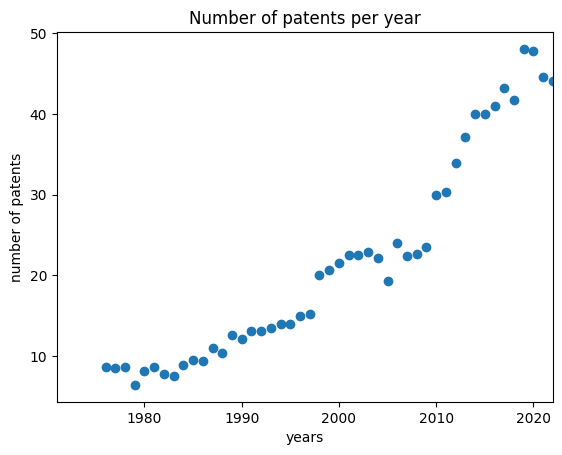

In [115]:
import matplotlib.pyplot as plt
import numpy as np
X_papers_rand = dist_year.keys()
Y_papers_rand = dist_year

X_patents_rand = list(dist_year.keys())
Y_patents_rand = 1000*np.array(list(dist_year.values()))/8169776


plt.figure()
plt.plot(X_patents_rand ,Y_patents_rand , 'o')
plt.xlim([1971, 2022])
plt.xlabel("years")
plt.ylabel("number of patents")
plt.title("Number of patents per year")
plt.show()

### Get corresponding numbers of patents per year

In [119]:
##get random patents

dic_patents_random = {}

#establishing the connection
conn = psycopg2.connect("user=" + user + " password=" + password )

#Creating a cursor object using the cursor() method
cursor = conn.cursor()


#for every years, get a logical number of patents
for year in dist_year_norm:
    url = "https://api.patentsview.org/patents/query?q={%22_and%22:[{%22_gte%22:{%22patent_date%22:%22" + str(year) + "-01-01%22}},{%22_lt%22:{%22patent_date%22:%22" + str(year + 1) +  "-01-01%22}}]}&f=[%22inventor_last_name%22,%22inventor_first_name%22,%22inventor_id%22,%22patent_number%22,%22patent_title%22,%22patent_abstract%22,%22cpc_group_id%22,%22cpc_subgroup_id%22,%22cpc_group_title%22,%22cpc_category%22,%22cpc_section_id%22,%22cpc_subsection_id%22,%22cpc_subgroup_title%22,%22cpc_subsection_title%22,%22assignee_organization%22,%22assignee_city%22,%22assignee_country%22,%22inventor_latitude%22,%22inventor_longitude%22,%22inventor_city%22,%22inventor_state%22,%22inventor_country%22,%22assignee_latitude%22,%22assignee_longitude%22,%22assignee_state%22,%22patent_date%22,%22patent_processing_time%22,%22rawinventor_last_name%22,%22rawinventor_first_name%22,%22cited_patent_number%22,%22citedby_patent_number%22,%22wipo_field_title%22,%22wipo_sector_title%22]&o={%22per_page%22:100}"
    patent_data = get_data(url)["patents"]
    if patent_data != None:
        number_patent = len(patent_data)
    else:
        number_patent = 0
    count = 0
    
    #keep only the patents with assignee locations
    for i in tqdm(range(number_patent)):
        if patent_data[i]["assignees"][0]["assignee_longitude"] != None:
            
            #get the useful data corresponding to the patent
            count += 1 
            patent_id = "us-" + patent_data[i]["patent_number"]
            dic_patents_random[patent_id] = {}
            dic_patents_random[patent_id]["patent_date"] = "\"" + patent_data[i]["patent_date"]
            dic_patents_random[patent_id]["encoded_title"] = model.encode(patent_data[i]["patent_title"] , convert_to_tensor = True).tolist()
            dic_patents_random[patent_id]["encoded_abstract"] = model.encode(patent_data[i]["patent_abstract"] , convert_to_tensor = True).tolist()
            dic_patents_random[patent_id]["co_inventors"] = [ name["inventor_first_name"] + " " + name["inventor_last_name"] for name in patent_data[i]["inventors"] if name["inventor_first_name"] != None] 
            if patent_data[i]["inventors"][0]["inventor_longitude"] != None:
                dic_patents_random[patent_id]["inventor_latitude"] = float(patent_data[i]["inventors"][0]["inventor_latitude"])
                dic_patents_random[patent_id]["inventor_longitude"] = float(patent_data[i]["inventors"][0]["inventor_longitude"])
            else:
                dic_patents_random[patent_id]["inventor_latitude"] = None
                dic_patents_random[patent_id]["inventor_longitude"] = None
            dic_patents_random[patent_id]["assignee_organization"] = patent_data[i]["assignees"][0]["assignee_organization"]

            if patent_data[i]["assignees"][0]["assignee_longitude"] != None:
                dic_patents_random[patent_id]["assignee_longitude"] = float(patent_data[i]["assignees"][0]["assignee_longitude"])
                dic_patents_random[patent_id]["assignee_latitude"] = float(patent_data[i]["assignees"][0]["assignee_latitude"])
            else:
                dic_patents_random[patent_id]["assignee_latitude"] = None
                dic_patents_random[patent_id]["assignee_longitude"] = None

            dic_patents_random[patent_id]["cited_papers"] = set()

            #get the cited papers
            text = """ SELECT work_id FROM non_patent_citations_matt_marx WHERE patent_id = '""" + patent_id + """'"""

            cursor.execute(text)  
            res = cursor.fetchall()

            for line in res:
                dic_patents_random[patent_id]["cited_papers"].add(line[0])

            dic_patents_random[patent_id]["cited_papers"] = list(dic_patents_random[patent_id]["cited_papers"])
        
        #keep only the right number of patents per year
        if count >= dist_year_norm[year]:
            break


 25%|██████████▌                               | 25/100 [00:00<00:01, 70.94it/s]

KeyboardInterrupt



In [122]:
##compare the papers with random patents and get the model's features

#compute random indexes to randomly compare patents with papers
indexes = np.random.randint(len(dic_patents_random), size=len(dic_papers)*15)
dic_neg  = {}
count = 0 

for i in tqdm(range(10)):#len(dic_papers))):
    orcid = list(dic_papers.keys())[i]
    data_author =  dic_papers[orcid]["data"] 
    
    #compare each paper with 3 random patents
    for k in range(3):
        for paper in dic_papers[orcid]["papers"]:
            index = indexes[count]
            data_patent = dic_patents_random[list(dic_patents_random.keys())[index]]
            count += 1
            data_paper = dic_papers[orcid]["papers"][paper]
            dic_neg[paper + " " + list(dic_patents_random.keys())[index]] = comparison_pairs(data_paper , data_patent  , data_author)
            dic_neg[paper + " " + list(dic_patents_random.keys())[index]]["orcid"] = orcid



100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 70.71it/s]


In [107]:
table_neg = pd.DataFrame(dic_neg).T
table_neg

,number_in_common_authors,list_in_common_authors,similarity_title,similarity_abstract,distance_assignees,distance_inventors,in_common_citing_papers,similarity_institution,date_likelihood,date_difference,publications_range,number_publications,orcid
W2053286399 US-6836906,0,[],0.058203,0.086193,5169.339821,5169.339821,0,0,-3.281648,6.9,26,200,https://orcid.org/0000-0003-3972-720X
W2089376561 US-7313834,0,[],0.065346,-0.031934,12521.410261,12779.118126,0,0,-2.900284,3.9,26,200,https://orcid.org/0000-0003-3972-720X
W1994621647 US-6981302,0,[],0.162335,0.04526,1043.404753,1032.890164,0,0,-3.124652,5.9,26,200,https://orcid.org/0000-0003-3972-720X
W2069700172 US-7640618,0,[],-0.028182,-0.098722,11239.126183,10922.676668,0,0,-2.787694,1.9,26,200,https://orcid.org/0000-0003-3972-720X
W2052037134 US-4180877,0,[],0.087429,-0.043429,2057.331211,2057.331211,0,0,-23.318385,31.9,26,200,https://orcid.org/0000-0003-3972-720X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
W2138067285 US-4180883,0,[],0.053556,0.057617,5786.457192,993.143893,0,0,-5000,24.97619,28,42,https://orcid.org/0000-0003-4803-8510
W1985560386 US-8621719,0,[],0.099705,0.095622,8513.944305,11147.84696,0,0,-10.438645,9.02381,28,42,https://orcid.org/0000-0003-4803-8510
W2048407382 US-7861330,0,[],-0.088724,-0.113508,None,None,0,0,-9.377176,6.02381,28,42,https://orcid.org/0000-0003-4803-8510
W2058543411 US-8341795,0,[],-0.009852,0.048688,5796.311345,5810.543185,0,0,-10.086745,8.02381,28,42,https://orcid.org/0000-0003-4803-8510


In [110]:
#drop the patents and papers with authors/inventors in common 

count = 0 
for elem in list(dic_neg.keys()):
    if dic_neg[elem]["number_in_common_authors"] > 0:
        count += 1
        dic_neg.pop(elem)
        
print("Number of dropped pairs:" , count)

Number of dropped pairs: 1


In [111]:
#save the negative training set

import json
json = json.dumps(dic_neg)
f = open(main_path + "train_the_model/negative_training_set.json","a")
f.write(json)
f.close()

# Machine Learning model

In [124]:
## load dictionary with the negative training set

f = open(main_path + "train_the_model/negative_training_set.json","r")
import json
dic_neg = json.load(f)

print("Number of negative pairs:" , len(dic_neg))

Number of negative pairs: 236512


In [125]:
## load dictionary with the distribution of the first names: 

f = open(main_path + "train_the_model/positive_training_set.json","r")
import json
dic_pos = json.load(f)

print("Number of positive pairs:" , len(dic_pos))

Number of positive pairs: 218841


In [126]:
#positive pairs:
for elem in dic_pos:
        
    #output of the model (do the paper and patent have an author in common, 1 = YES)
    dic_pos[elem]["output"] = 1
    
    
dic_neg2 = {}
#negative pairs (keep the right number of datapoints):
for elem in list(dic_neg.keys())[:len(dic_pos)]:
    
    dic_neg2[elem] = dic_neg[elem]
    #output of the model (do the paper and patent have an author in common, 0 = NO)
    dic_neg[elem]["output"] = 0
    
    #add artificially 1 to the negative set --> we will use the model on paper and patent with an author/inventor name in common 
    dic_neg[elem]["number_in_common_authors"] += 1



In [127]:
dic_training_set = {**dic_pos , **dic_neg2 } 
print("Number of data points: " , len(dic_training_set))
print("Number of negative data points: " , len(dic_neg2))
print("Number of positive data points: " ,len(dic_pos))

for elem in list(dic_training_set.keys()):
    if dic_training_set[elem]["similarity_title"] == None:
        dic_training_set.pop(elem)

Number of data points:  437682
Number of negative data points:  218841
Number of positive data points:  218841


## Functions

In [128]:
## get accuracy metrics to evaluate Machine Learning models

from sklearn.metrics import confusion_matrix


# Below is the code for calcultating the accuracy, the TPR and the FPR.
def accuracy(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    accuracy = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
    return accuracy

def TPR(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TPR = cm[1][1]/(cm[1][1]+cm[1][0])
    return TPR

def FPR(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    FPR = cm[0][1]/(cm[0][1]+cm[0][0])
    return FPR

## Data Analysis

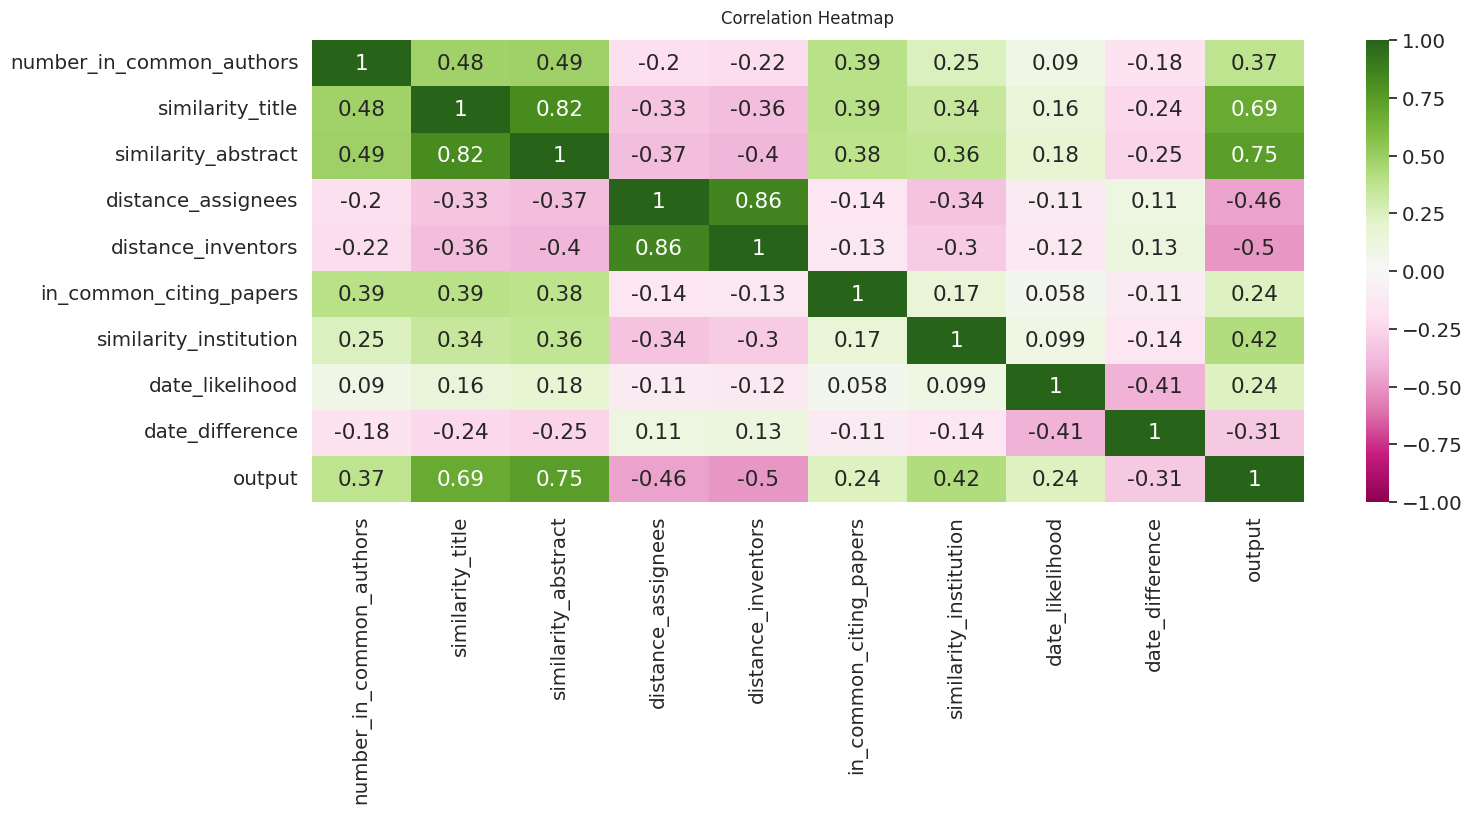

In [134]:
##correlation matrix

df = pd.DataFrame(dic_training_set).T
df = df.drop( [ "list_in_common_authors" , "number_publications" ,"publications_range"  , "orcid" ]  , axis = 1)
df = df.sample(frac=1).reset_index(drop=True)
df = df.apply(pd.to_numeric , errors='coerce')
df = df.apply(pd.to_numeric , errors='coerce')

plt.figure(figsize=(16, 6))
sns.set(font_scale=1.3)
heatmap = sns.heatmap(df[:10000].corr(), vmin=-1, vmax=1, annot=True , center = 0 , cmap="PiYG")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Text(0.5, 1.0, "Date difference between the patent's date \nand the mean of the author publication's dates")

<Figure size 700x400 with 0 Axes>

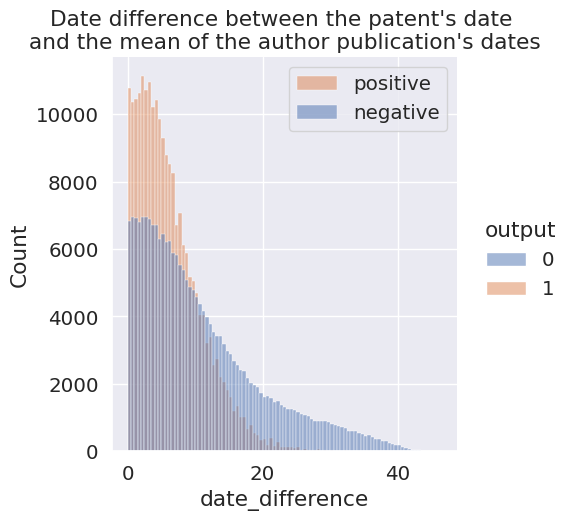

In [137]:
plt.figure(figsize=(7, 4))

sns.displot(data=df, x="date_difference", hue="output" , binwidth= 0.5 )
plt.legend(["positive" , "negative"])
plt.title("Date difference between the patent's date \nand the mean of the author publication's dates")

## Training set

In [138]:
#convert the data into pandas frames
#mix randomly the index
#transform every values to numeric values

training_set = pd.DataFrame(dic_training_set)
training_set = training_set.T
training_set = training_set.drop( [ "list_in_common_authors" , "number_publications" ,"publications_range" , "orcid"   ]  , axis = 1)
training_set = training_set.sample(frac=1).reset_index(drop=True)
training_set = training_set.apply(pd.to_numeric , errors='coerce')


In [139]:
training_set

,number_in_common_authors,similarity_title,similarity_abstract,distance_assignees,distance_inventors,in_common_citing_papers,similarity_institution,date_likelihood,date_difference,output
0,1,0.073040,0.055222,3901.483991,3891.999588,0,0,-4.460608,16.882051,0
1,5,0.427952,0.206428,8655.727760,2.684206,10,0,-4.440430,9.279070,1
2,2,0.490675,0.219465,668.243194,2163.425368,1,0,-3.429087,6.400000,1
3,1,0.430890,0.514855,2.030874,9.951627,11,2,-3.102944,5.525000,1
4,1,-0.012449,-0.091965,632.001366,639.543707,0,0,-2.881239,2.432000,0
...,...,...,...,...,...,...,...,...,...,...
437618,1,0.062980,-0.009182,8184.616476,8027.320969,0,0,-3.730445,1.810000,0
437619,1,-0.125663,-0.142014,6116.052364,6109.270709,0,0,-2.831369,0.222222,0
437620,1,0.122469,0.202166,373.352714,20.070522,0,0,-3.740071,5.873563,1
437621,1,0.142785,0.197307,6963.517198,7682.940008,0,0,-4.569246,6.175000,0


In [140]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437623 entries, 0 to 437622
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   number_in_common_authors  437623 non-null  int64  
 1   similarity_title          437623 non-null  float64
 2   similarity_abstract       437060 non-null  float64
 3   distance_assignees        370698 non-null  float64
 4   distance_inventors        372984 non-null  float64
 5   in_common_citing_papers   437623 non-null  int64  
 6   similarity_institution    437623 non-null  int64  
 7   date_likelihood           437623 non-null  float64
 8   date_difference           437623 non-null  float64
 9   output                    437623 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 33.4 MB


### Training set with distance 

In [141]:
#keep only the non null values

training_set = training_set[training_set["similarity_abstract"].notnull()]

X = training_set[training_set["distance_inventors"].notnull()]
X = X[X["distance_assignees"].notnull()]
y = X["output"]
X = X.drop(['output'] ,  axis = 1)

#80% of the data from the training set while 20% form the testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [142]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367833 entries, 0 to 437622
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   number_in_common_authors  367833 non-null  int64  
 1   similarity_title          367833 non-null  float64
 2   similarity_abstract       367833 non-null  float64
 3   distance_assignees        367833 non-null  float64
 4   distance_inventors        367833 non-null  float64
 5   in_common_citing_papers   367833 non-null  int64  
 6   similarity_institution    367833 non-null  int64  
 7   date_likelihood           367833 non-null  float64
 8   date_difference           367833 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 28.1 MB


### Training set without distance

In [72]:
#drop the distance features

training_set = training_set[training_set["similarity_abstract"].notnull()]

X = training_set.drop(['output' , 'distance_assignees' , 'distance_inventors' ] ,  axis = 1)
y = training_set["output"]

#80% of the data from the training set while 20% form the testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 437060 entries, 0 to 437622
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   number_in_common_authors  437060 non-null  int64  
 1   similarity_title          437060 non-null  float64
 2   similarity_abstract       437060 non-null  float64
 3   in_common_citing_papers   437060 non-null  int64  
 4   similarity_institution    437060 non-null  int64  
 5   date_likelihood           437060 non-null  float64
 6   date_difference           437060 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 26.7 MB


## Logistic model 

In [76]:
#run the logistic model

import statsmodels.formula.api as smf

train = X_train.copy()
train['output'] = y_train

#regression_model = smf.logit('output ~ number_in_common_authors + similarity_title + similarity_abstract + distance_assignees + distance_inventors  + in_common_citing_papers + similarity_institution  + date_likelihood + date_difference' , data=train , missing='drop').fit()
regression_model = smf.logit('output ~ number_in_common_authors + similarity_title + similarity_abstract  + in_common_citing_papers + similarity_institution  + date_likelihood + date_difference' , data=train , missing='drop').fit()

print(regression_model.summary())

         Current function value: 0.172947
         Iterations: 35


/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                 output   No. Observations:               349648
Model:                          Logit   Df Residuals:                   349640
Method:                           MLE   Df Model:                            7
Date:                Wed, 07 Feb 2024   Pseudo R-squ.:                  0.7505
Time:                        17:38:01   Log-Likelihood:                -60471.
converged:                      False   LL-Null:                   -2.4236e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -30.3424   1.03e+04     -0.003      0.998   -2.03e+04    2.02e+04
number_in_common_authors    28.0278   1.03e+04      0.003      0.998   -2.02e+04    2.03e

In [77]:
#evaluate the logistic model on the testing set
test = X_test.copy()
test['output'] = y_test



y_pred = regression_model.predict(test).to_numpy()
y_test_log = y_test 
## Baseline model:
y_baseline = np.zeros((len(y_pred)))

print(" The accuracy of the baseline model on the test set is equal to" , accuracy(y_test_log,y_baseline))  
print(" The TPR of the logistic baseline model on the test set is equal to" , TPR(y_test_log,y_baseline))  
print(" The FPR of the logistic baseline model on the test set is equal to" , FPR(y_test_log,y_baseline))  


print(" ")
n = len(y_pred)
y_pred_log = [0]*n
for i in tqdm(range(n)) :
    if y_pred[i] >= 0.50 :
            y_pred_log[i] = 1
print(" The accuracy of the logistic regression method on the test set is equal to" , accuracy(y_test_log,y_pred_log))  
print(" The TPR of the logistic regression method on the test set is equal to" , TPR(y_test_log,y_pred_log))  
print(" The FPR of the logistic regression method on the test set is equal to" , FPR(y_test_log,y_pred_log))  

 The accuracy of the baseline model on the test set is equal to 0.4977348647782913
 The TPR of the logistic baseline model on the test set is equal to 0.0
 The FPR of the logistic baseline model on the test set is equal to 0.0
 


100%|████████████████████████████████| 87412/87412 [00:00<00:00, 1980608.94it/s]

 The accuracy of the logistic regression method on the test set is equal to 0.9345742003386263
 The TPR of the logistic regression method on the test set is equal to 0.9107598396501457
 The FPR of the logistic regression method on the test set is equal to 0.04139468603475223


## Decision tree

/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_

Node count = 43


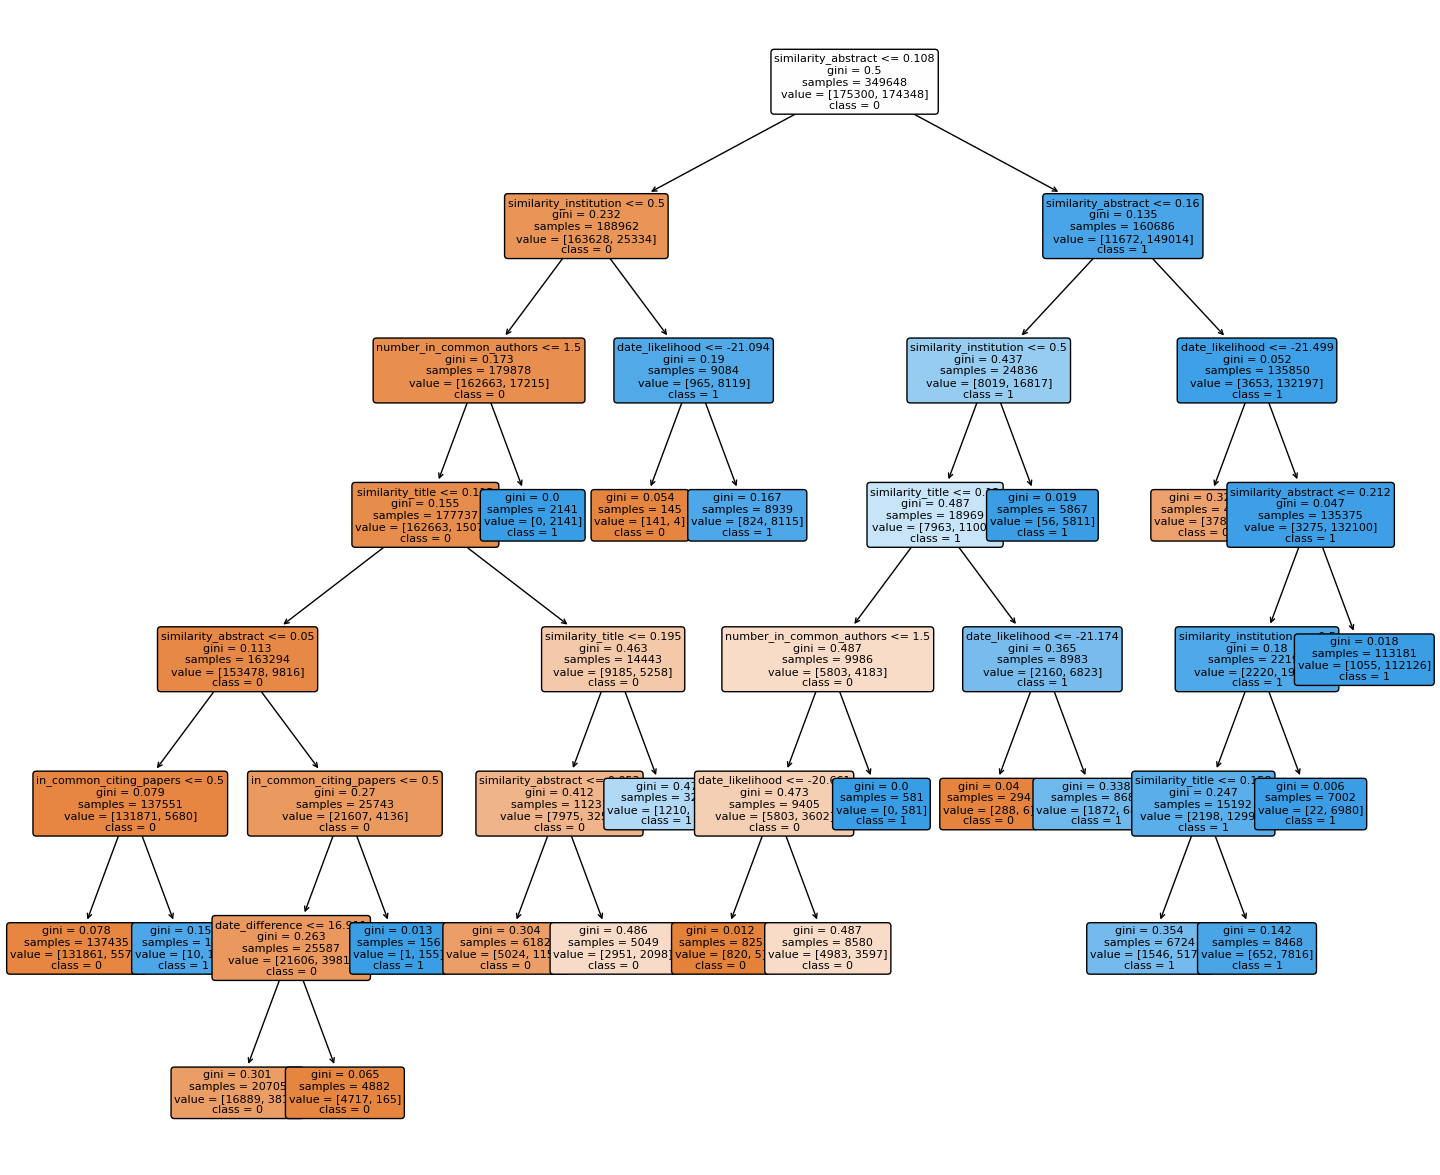

In [78]:
#run the decision tree model

from sklearn.tree import DecisionTreeClassifier


dtc = DecisionTreeClassifier(min_samples_leaf=20, 
                             ccp_alpha= 0.0005,
                             criterion = 'gini',
                             random_state = 88)

dtc = dtc.fit(X_train, y_train)

#below is the code for plotting the decision tree classifier and counting the number of nodes. 


import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(18,15))
plot_tree(dtc, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=8
         ) 
plt.show()

In [79]:
#evaluate the decision tree model on the testing set


y_pred = dtc.predict(X_test)
y_baseline = np.zeros((len(y_pred)))

print(" The accuracy of the baseline model on the test set is equal to" , accuracy(y_test,y_baseline))  
print(" The TPR of the logistic baseline model on the test set is equal to" , TPR(y_test,y_baseline))  
print(" The FPR of the logistic baseline model on the test set is equal to" , FPR(y_test,y_baseline))  


print( " ")
print(" The accuracy of the logistic regression method on the test set is equal to" , accuracy(y_test,y_pred))  
print(" The TPR of the logistic regression method on the test set is equal to" , TPR(y_test,y_pred))  
print(" The FPR of the logistic regression method on the test set is equal to" , FPR(y_test,y_pred))  


 The accuracy of the baseline model on the test set is equal to 0.4977348647782913
 The TPR of the logistic baseline model on the test set is equal to 0.0
 The FPR of the logistic baseline model on the test set is equal to 0.0
 
 The accuracy of the logistic regression method on the test set is equal to 0.9310620967372901
 The TPR of the logistic regression method on the test set is equal to 0.9038128644314869
 The FPR of the logistic regression method on the test set is equal to 0.041440654592258895


/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Gradient boosting

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

gdb = GradientBoostingClassifier(max_features=5 ,n_estimators = 100)
gdb.fit(X_train, y_train)

/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_

GradientBoostingClassifier(max_features=5)

In [61]:
#evaluate the random forest model on the testing set


y_pred = gdb.predict_proba(X_test)


## Baseline model:
y_baseline = np.zeros((len(y_pred)))

print(" The accuracy of the baseline model on the test set is equal to" , accuracy(y_test,y_baseline))  
print(" The TPR of the logistic baseline model on the test set is equal to" , TPR(y_test,y_baseline))  
print(" The FPR of the logistic baseline model on the test set is equal to" , FPR(y_test,y_baseline))  

print(" ") 

n = len(y_pred)
y_pred_gdb = [0]*n
for i in range(n) :
    if y_pred[i][1] >= 0.5 :
            y_pred_gdb[i] = 1

print(" The accuracy of the gradient boosting method on the test set is equal to" , accuracy(y_test,y_pred_gdb))  
print(" The TPR of the gradient boosting method on the test set is equal to" , TPR(y_test,y_pred_gdb))  
print(" The FPR of the gradient boosting method on the test set is equal to" , FPR(y_test,y_pred_gdb))  

/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


 The accuracy of the baseline model on the test set is equal to 0.511968681609961
 The TPR of the logistic baseline model on the test set is equal to 0.0
 The FPR of the logistic baseline model on the test set is equal to 0.0
 
 The accuracy of the gradient boosting method on the test set is equal to 0.9550070004213845
 The TPR of the gradient boosting method on the test set is equal to 0.939754338077598
 The FPR of the gradient boosting method on the test set is equal to 0.030453483432455394


In [62]:
# Get numerical feature importances


#importances = sorted(list(rf.feature_importances_) , reverse = True)
importances = list(gdb.feature_importances_)


feature_list = list(X_test.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#feature_importances = feature_importances
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: similarity_abstract  Importance: 0.3956
Variable: similarity_title     Importance: 0.3063
Variable: distance_inventors   Importance: 0.147
Variable: distance_assignees   Importance: 0.0977
Variable: similarity_institution Importance: 0.0163
Variable: date_likelihood      Importance: 0.0127
Variable: number_in_common_authors Importance: 0.0123
Variable: in_common_citing_papers Importance: 0.0066
Variable: date_difference      Importance: 0.0055


[None, None, None, None, None, None, None, None, None]

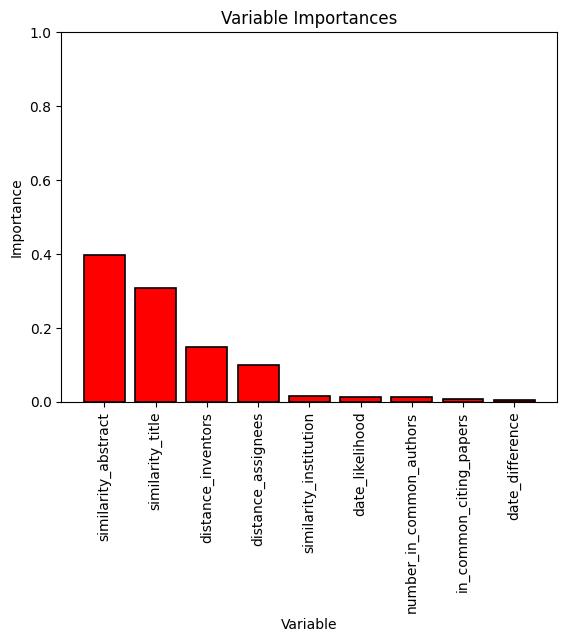

In [63]:
#plot the feature importance 

x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, sorted(importances , reverse = True), orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2 )
# Tick labels for x axis
plt.xticks(x_values, list(np.array(feature_importances)[:,0]), rotation='vertical')
plt.ylim((0,1))
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Random forest

### Model

In [94]:
#run the random forest


from sklearn.ensemble import RandomForestClassifier

X_train_np = X_train[['number_in_common_authors', 'similarity_title', 'similarity_abstract',
       'distance_assignees', 'distance_inventors', 'in_common_citing_papers',
       'similarity_institution', 'date_likelihood', 'date_difference']].to_numpy()
y_train_np = y_train.to_numpy()

rf = RandomForestClassifier( n_jobs = 12 )
rf.fit(X_train_np, y_train_np)

RandomForestClassifier(n_jobs=12)

### Analysis of the results

In [ ]:
#load the model from disk
rf_filename_distance = main_path + 'train_the_model/random_forest_distance.sav'
random_forest_distance = pickle.load(open(rf_filename_distance, 'rb'))

rf_filename_no_distance = main_path + 'train_the_model/random_forest_no_distance.sav'
random_forest_no_distance = pickle.load(open(rf_filename_no_distance, 'rb'))


rf = rf_filename_distance

In [95]:
#evaluate the random forest model on the testing set

X_test_np = X_test[['number_in_common_authors', 'similarity_title', 'similarity_abstract',
       'distance_assignees', 'distance_inventors', 'in_common_citing_papers',
       'similarity_institution', 'date_likelihood', 'date_difference']].to_numpy()
y_pred = rf.predict_proba(X_test_np)


## Baseline model:
y_baseline = np.zeros((len(y_pred)))

print(" The accuracy of the baseline model on the test set is equal to" , accuracy(y_test,y_baseline))  
print(" The TPR of the logistic baseline model on the test set is equal to" , TPR(y_test,y_baseline))  
print(" The FPR of the logistic baseline model on the test set is equal to" , FPR(y_test,y_baseline))  

print(" ") 

n = len(y_pred)
y_pred_rf = [0]*n
for i in range(n) :
    if y_pred[i][1] >= 0.5 :
            y_pred_rf[i] = 1

print(" The accuracy of the random forest method on the test set is equal to" , accuracy(y_test,y_pred_rf))  
print(" The TPR of the random forest method on the test set is equal to" , TPR(y_test,y_pred_rf))  
print(" The FPR of the random forest method on the test set is equal to" , FPR(y_test,y_pred_rf))  

 The accuracy of the baseline model on the test set is equal to 0.5069800318077399
 The TPR of the logistic baseline model on the test set is equal to 0.0
 The FPR of the logistic baseline model on the test set is equal to 0.0
 
 The accuracy of the random forest method on the test set is equal to 0.9621025731645982
 The TPR of the random forest method on the test set is equal to 0.9514199062586159
 The FPR of the random forest method on the test set is equal to 0.02750891492613347


### Features importance

In [96]:
# Get numerical feature importances


#importances = sorted(list(rf.feature_importances_) , reverse = True)
importances = list(rf.feature_importances_)


feature_list = list(X_test.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#feature_importances = feature_importances
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: similarity_abstract  Importance: 0.3453
Variable: similarity_title     Importance: 0.2298
Variable: distance_inventors   Importance: 0.1853
Variable: distance_assignees   Importance: 0.1022
Variable: similarity_institution Importance: 0.0384
Variable: date_likelihood      Importance: 0.0311
Variable: date_difference      Importance: 0.028
Variable: number_in_common_authors Importance: 0.0253
Variable: in_common_citing_papers Importance: 0.0146


[None, None, None, None, None, None, None, None, None]

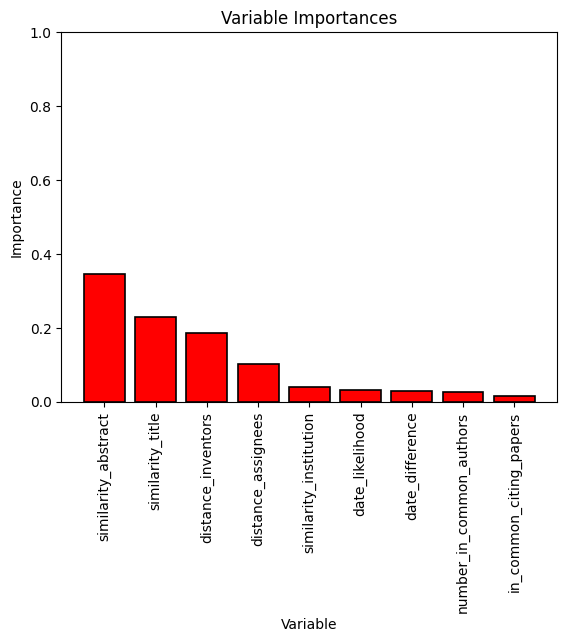

In [97]:
#plot the feature importance 

x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, sorted(importances , reverse = True), orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2 )
# Tick labels for x axis
plt.xticks(x_values, list(np.array(feature_importances)[:,0]), rotation='vertical')
plt.ylim((0,1))
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

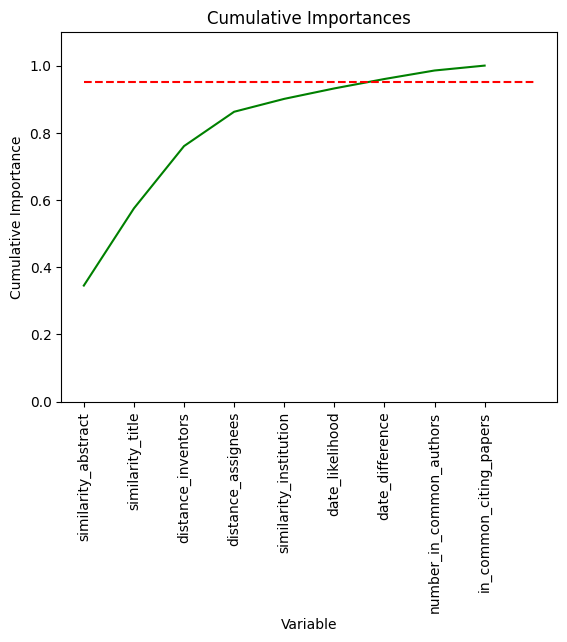

In [98]:
#plot the feature importance 


# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
plt.ylim((0,1.1))
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

### Distribution results

Text(0.5, 9.444444444444438, 'Prediction')

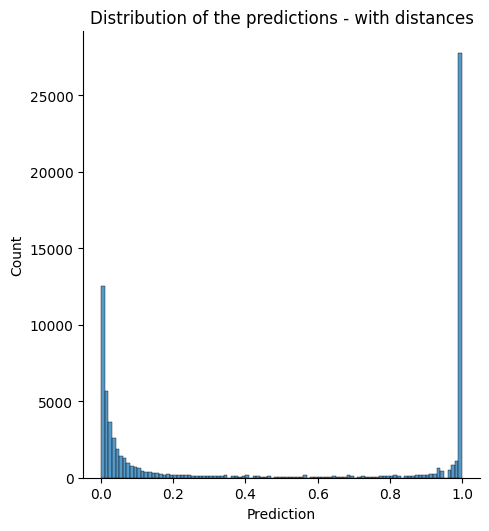

In [100]:
#plot the distribution of the results

sns.displot(y_pred[:,1] , binwidth=0.01 )
plt.title("Distribution of the predictions - with distances")
plt.xlabel("Prediction")

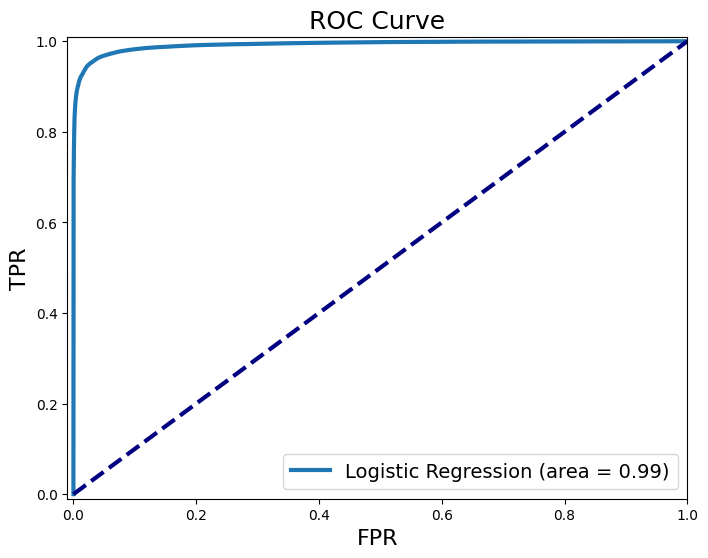

In [101]:
#plot the ROC curve (TPR as a function of the FPR)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

### Fine tuning

In [145]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings
import os
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Create the parameter grid based on the results of random search 
random_grid = {'bootstrap': [True],
 'max_depth': [5 ,10, 20],
 'max_features': ['sqrt', "log2"],
 'min_samples_leaf': [5,10],
 'min_samples_split': [5,10,20],
 'n_estimators': [20, 50 , 100]}
# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 12)

# Fit the grid search to the data
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=12,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [5, 10],
                                        'min_samples_split': [5, 10, 20],
                                        'n_estimators': [20, 50, 100]},
                   random_state=42, verbose=2)

In [147]:
rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': True}

In [148]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [150]:
best_grid = rf_random.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Model Performance
Average Error: 0.0419 degrees.
Accuracy = -inf%.
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time=  12.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=  41.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=  24.4s
[CV] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=20; total time=   4.9s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=20; total time=   8.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  45.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=20; to

### Saving the model

In [86]:
#save the model

import pickle

filename = main_path + 'train_the_model/random_forest_distance.sav'
pickle.dump(rf, open(filename, 'wb'))